In [14]:
import os
print(os.getcwd())


/Users/divyanshutripathi


In [18]:
with open('/Users/divyanshutripathi/Downloads/user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

In [20]:
print(data[0])


{'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}


In [22]:
import pandas as pd

df = pd.DataFrame(data)


In [18]:
print(df.head())

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [20]:
print(df['action'].value_counts())

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64


In [22]:
print(df.columns)

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')


In [24]:
print(df['actionData'].iloc[0])


{'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}


In [26]:
def extract_amount_usd(row):
    data = row['actionData']
    try:
        amount = float(data.get('amount', 0))
        price = float(data.get('assetPriceUSD', 1))
        symbol = data.get('assetSymbol', '')
        decimals = 6 if symbol == 'USDC' else 18  # You can add more symbols as needed
        return (amount / (10 ** decimals)) * price
    except:
        return 0

df['amount'] = df.apply(extract_amount_usd, axis=1)


In [28]:
print(df[['userWallet', 'action', 'amount']].head())


                                   userWallet            action       amount
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  1987.663655
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit   285.694480
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit     0.000922
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit     0.004230
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying     0.502616


In [34]:
# Group transactions by wallet
wallet_groups = df.groupby('userWallet')

In [36]:
# Create list to store feature dictionaries
features = []


In [38]:




for wallet, group in wallet_groups:
    total_deposit = group[group['action'].str.lower() == 'deposit']['amount'].sum()
    total_borrow = group[group['action'].str.lower() == 'borrow']['amount'].sum()
    total_repay = group[group['action'].str.lower() == 'repay']['amount'].sum()
    total_liquidations = group[group['action'].str.lower() == 'liquidationcall'].shape[0]
    total_actions = group.shape[0]
    
    borrow_deposit_ratio = total_borrow / total_deposit if total_deposit > 0 else 0
    repay_ratio = total_repay / total_borrow if total_borrow > 0 else 0

    features.append({
        'wallet': wallet,
        'total_deposit': total_deposit,
        'total_borrow': total_borrow,
        'total_repay': total_repay,
        'liquidations': total_liquidations,
        'borrow_to_deposit': borrow_deposit_ratio,
        'repay_ratio': repay_ratio,
        'total_actions': total_actions
    })



In [ ]:
# Create features DataFrame
features_df = pd.DataFrame(features)

In [32]:
print(features_df.head())


                                       wallet  total_deposit  total_borrow  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6    1987.663655      0.000000   
1  0x000000000051d07a4fb3bd10121a343d85818da6     285.694480      0.000000   
2  0x000000000096026fb41fc39f9875d164bd82e2dc       0.005152      0.000000   
3  0x0000000000e189dd664b9ab08a33c4839953852c       0.000000      0.000000   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee  703042.193633  60297.620862   

    total_repay  liquidations  borrow_to_deposit   repay_ratio  total_actions  
0  0.000000e+00             0           0.000000  0.000000e+00              1  
1  0.000000e+00             0           0.000000  0.000000e+00              1  
2  0.000000e+00             0           0.000000  0.000000e+00              2  
3  0.000000e+00             0           0.000000  0.000000e+00             17  
4  7.015026e-08             0           0.085767  1.163400e-12            399  


In [41]:
def score_wallet(row):
    score = 0

    # Normalize deposit (scale 0 to 300)
    max_deposit = features_df['total_deposit'].max()
    score += (row['total_deposit'] / max_deposit) * 300 if max_deposit > 0 else 0

    # Borrow to deposit score (ideal range ~0.3 to 0.7)
    b2d = row['borrow_to_deposit']
    if 0.3 <= b2d <= 0.7:
        score += 200
    elif 0.1 <= b2d < 0.3 or 0.7 < b2d <= 1:
        score += 100
    else:
        score += 0

    # Repay ratio score (closer to 1 is better)
    repay = row['repay_ratio']
    if repay >= 0.9:
        score += 200
    elif repay >= 0.5:
        score += 100
    else:
        score += 0

    # Liquidations (penalty: more liquidations = less score)
    score += max(0, 100 - (row['liquidations'] * 20))  # Deduct 20 pts per liquidation

    # Normalize total actions (scale 0 to 200)
    max_actions = features_df['total_actions'].max()
    score += (row['total_actions'] / max_actions) * 200 if max_actions > 0 else 0

    return min(1000, round(score))  # Final score capped at 1000


In [43]:
features_df['score'] = features_df.apply(score_wallet, axis=1)


In [45]:
print(features_df[['wallet', 'score']].sort_values(by='score', ascending=False).head())


                                          wallet  score
137   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62    797
54    0x000f7f22bfc28d940d4b68e13213ab17cf107790    644
3178  0x058b10cbe1872ad139b00326686ee8ccef274c58    607
2648  0x049940feda4277b7f01ef10fca0b975c541d8fca    534
2801  0x04ddf96a61c4c44731f04df4e963f61cfe3c9c6d    532


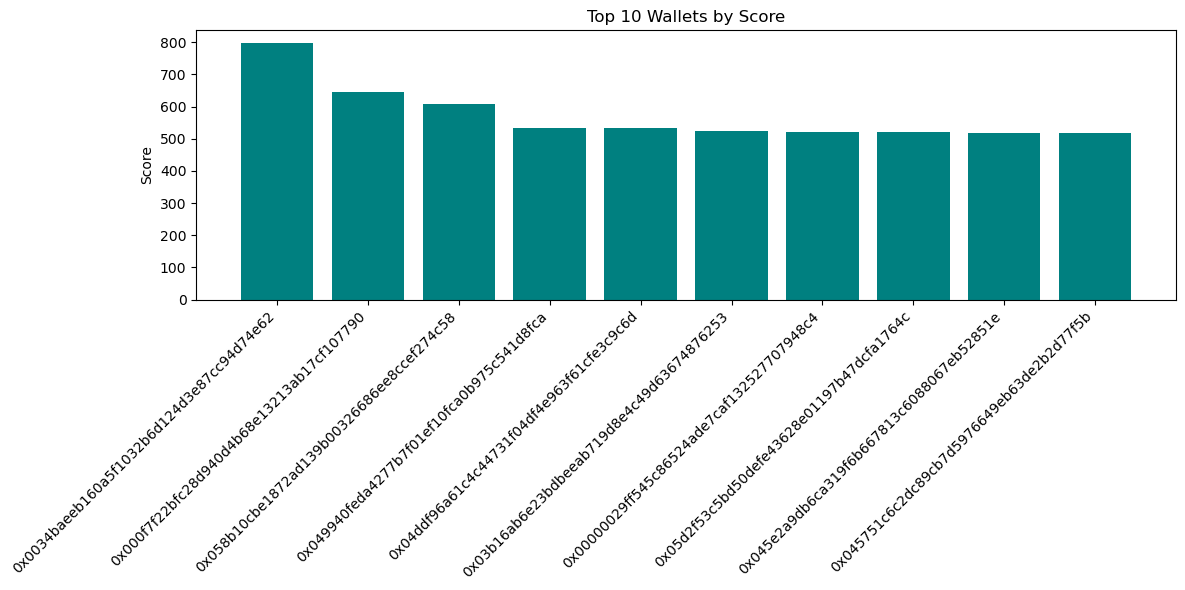

In [47]:
import matplotlib.pyplot as plt

top_wallets = features_df.sort_values(by='score', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_wallets['wallet'], top_wallets['score'], color='teal')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Top 10 Wallets by Score')
plt.tight_layout()
plt.show()


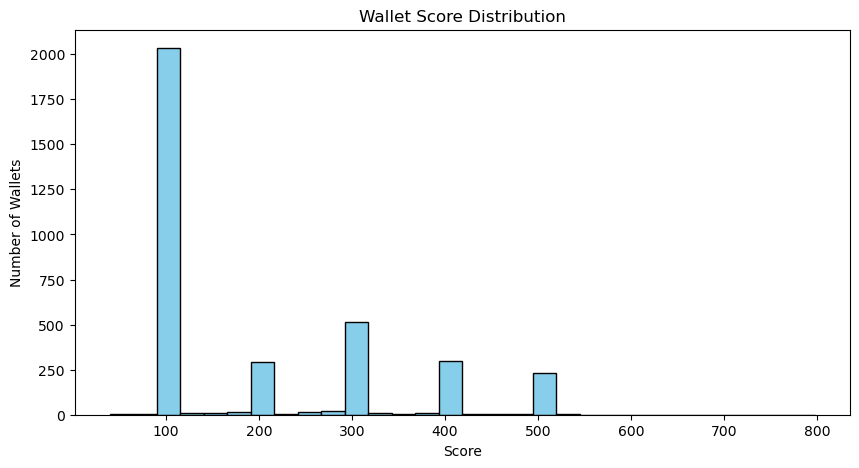

In [49]:
plt.figure(figsize=(10, 5))
plt.hist(features_df['score'], bins=30, color='skyblue', edgecolor='black')
plt.title("Wallet Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.show()


In [51]:
features_df.to_csv('wallet_scores.csv', index=False)
print("Exported to wallet_scores.csv")


Exported to wallet_scores.csv
